
# Big Mountain Resort Ticket Price Prediction

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Problem" data-toc-modified-id="Problem-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Problem</a></span></li><li><span><a href="#Objective" data-toc-modified-id="Objective-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Objective</a></span></li></ul></li><li><span><a href="#Data-Information" data-toc-modified-id="Data-Information-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Information</a></span><ul class="toc-item"><li><span><a href="#Data-Wrangling" data-toc-modified-id="Data-Wrangling-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data Wrangling</a></span></li><li><span><a href="#Explore-Data" data-toc-modified-id="Explore-Data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Explore Data</a></span></li></ul></li><li><span><a href="#Models" data-toc-modified-id="Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><span><a href="#Baseline-model" data-toc-modified-id="Baseline-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Baseline model</a></span></li><li><span><a href="#Initial-model" data-toc-modified-id="Initial-model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Initial model</a></span></li><li><span><a href="#Linear-regression-model-with-feature-selection-k" data-toc-modified-id="Linear-regression-model-with-feature-selection-k-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Linear regression model with feature selection k</a></span></li><li><span><a href="#Random-forest-model" data-toc-modified-id="Random-forest-model-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Random forest model</a></span></li><li><span><a href="#Paramters-optimization" data-toc-modified-id="Paramters-optimization-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Paramters optimization</a></span></li></ul></li><li><span><a href="#Evaluation-of-model-Results" data-toc-modified-id="Evaluation-of-model-Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation of model Results</a></span></li><li><span><a href="#Scenarios-Tests" data-toc-modified-id="Scenarios-Tests-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Scenarios Tests</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Futher-Work" data-toc-modified-id="Futher-Work-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Futher Work</a></span></li></ul></div>

## Introduction

Big Mountain Resort is a ski resort located in Montana with 105 trails, 11 lifts, 2T-bars and 1 magic carpet for skiers of all levels. And it wants to maximize its return based on its position in the market. An additional lift chair has been added with operating cost of 1.5M this season.

### Problem

The resort wants to find out which facilities matter most to visitors and need a guidance to select a better pricing strategy to increase revenue. 

### Objective

In [ ]:
The objective is to come up with a predictive model for adult ticket price for ski resorts based on the current market.

## Data Information

### Data Wrangling

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from library.sb_utils import save_file

In [3]:
# the supplied CSV data file is the raw_data directory
ski_data = pd.read_csv('../raw_data/ski_resort_data.csv')

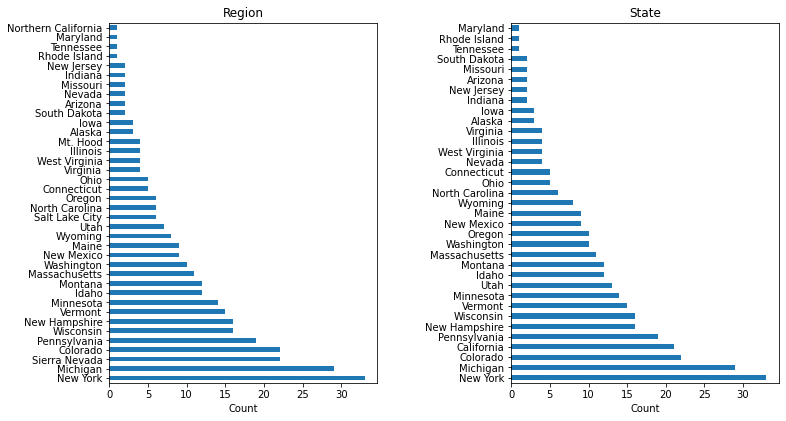

In [4]:
#Create two subplots on 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(12,10))

ski_data.Region.value_counts().plot(kind='barh', ax=ax[0])
ax[0].set_title('Region')
ax[0].set_xlabel('Count')

ski_data.state.value_counts().plot(kind='barh', ax=ax[1])
ax[1].set_title('State')
ax[1].set_xlabel('Count')

plt.subplots_adjust(bottom=0.3, top=0.8, wspace=0.5, hspace=0);

The original data has 330 rows and 27 features(columns). Big Mountain resort is found located in Montana with no much data missing.

All data across 35 states are belonging to the same market share. For the best practice, we may need consult the client or experts for treating states equivalently or differently.

In [5]:
ticket_prices = pd.melt(ski_data[['state', 'AdultWeekday', 'AdultWeekend']], 
                        id_vars= 'state', 
                        var_name= 'Ticket', 
                        value_vars=['AdultWeekday', 'AdultWeekend'], 
                        value_name= 'Price')

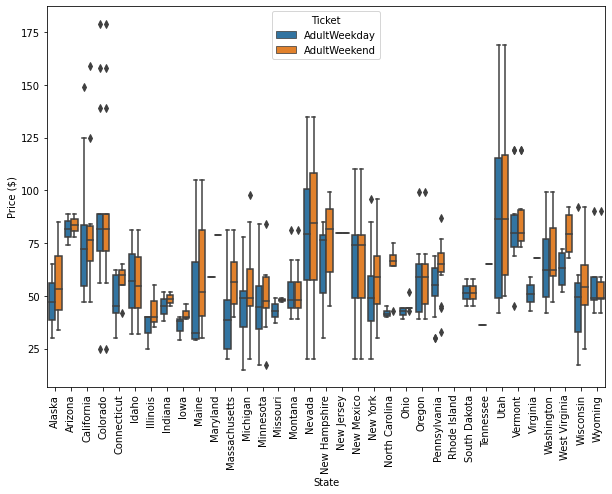

In [7]:
plt.subplots(figsize=(10, 7))
sns.boxplot(x='state', y='Price', hue='Ticket', data=ticket_prices)
plt.xticks(rotation='vertical')
plt.ylabel('Price ($)')
plt.xlabel('State');

There are two kinds of ticket price: AdultWeekday and AdultWeekend (the price of an adult weekday/weekend ticket). 

The target feature 'the ticket price' is missing 15-16% of values. Some States show a marked difference between weekday and weekend ticket prices. 

The distribution for weekday and weekend prices of Big Mountain Resort seemed equal. Weekend prices have the least missing values of the two, so the weekday prices is dropped and only keep the rows that have weekend price for the model.

### Explore Data

PCA is implented to reduce multiple features from high dimension to lower dimension. The reconstructed data is scaled, fit the PCA transformation, and apply the transformation to the scaled data to create the derived features. Finally explore how the original features contribute to these derived features.

The scaled features have mean of zero and standard deviation of 1.0 (use the biased estimator for std of the sample it was given; *.scale(ddof=0))

In [8]:
state_summary = pd.read_csv('../data/state_summary.csv')

In [9]:
state_summary['resorts_per_100kcapita'] = 100_000 * state_summary.resorts_per_state / state_summary.state_population
state_summary['resorts_per_100ksq_mile'] = 100_000 * state_summary.resorts_per_state / state_summary.state_area_sq_miles
state_summary.drop(columns=['state_population', 'state_area_sq_miles'], inplace=True)
state_summary.head()

,state,resorts_per_state,state_total_skiable_area_ac,state_total_days_open,state_total_terrain_parks,state_total_nightskiing_ac,resorts_per_100kcapita,resorts_per_100ksq_mile
0,Alaska,3,2280.0,345.0,4.0,580.0,0.410091,0.450867
1,Arizona,2,1577.0,237.0,6.0,80.0,0.027477,1.754540
2,California,21,25948.0,2738.0,81.0,587.0,0.053148,12.828736
3,Colorado,22,43682.0,3258.0,74.0,428.0,0.382028,21.134744
4,Connecticut,5,358.0,353.0,10.0,256.0,0.140242,90.203861


In [16]:
state_summary_scale = state_summary.set_index('state')
state_summary_index = state_summary_scale.index
state_summary_columns = state_summary_scale.columns

In [17]:
state_summary_scale = scale(state_summary_scale)
state_summary_scaled_df = pd.DataFrame(state_summary_scale, columns=state_summary_columns)
state_pca = PCA().fit(state_summary_scale)

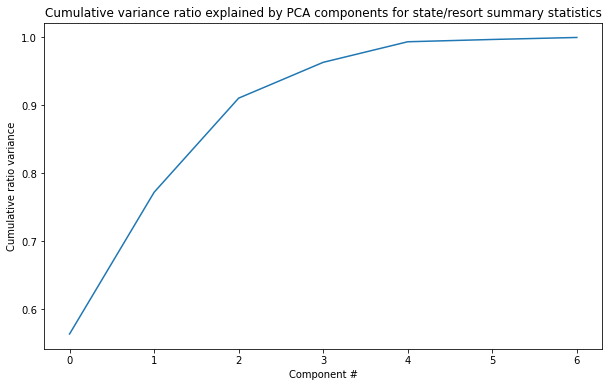

In [18]:
plt.subplots(figsize=(10, 6))
plt.plot(state_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for state/resort summary statistics');


The first two components seem to account for over 75% of the variance (resorts_per_state; state_total_skiable_area_ac;) 

The meaningful features correlated to the target feature 'AdultWeekend ticket price' are:

1) Runs, total chairs and Snow Making_ac are useful;  Visitors may value more guaranteed snow, which would need more cost of snow making equipment, which would drive both prices and costs up.

2) 'resort_night_skiing_state_ratio' may seize a greater share of night skiing capacity which is positive for the higher price.

3)  Price per visitor is high but the number of visitors may be low. The number of visitors per year is useful but missing in data. 

4) No fast quads appears limit the ticket price; a wide area of the resort with a small number of fast quads may be beneficial to ticket price.

## Models

### Baseline model

Make the baseline model using the mean of the known values as a predictor and all features in the data. 
The mode has R2-score of negative value, and a mean absolute error(mae) of $19. It suggests about off $19 based on an average of known values.

### Initial model

Both mean and median are tested to perform imputation to train and test split.

The model performance has r2-score of 67%, a mean absolute error(mae) of $10.

### Linear regression model with feature selection k

In the model pipeline: sklearn feature selection function: SelectKBest and k=8 (an initial rapid increase of the variance of the results with the best selected k value) is added.

The linear model has R2-score of 79%, mae of 11.79 USD and std 𝑜𝑓 1.6. It suggests the price will be off between $10.19 and $13.39.

### Random forest model

The random forest model has R2-score of 70% and mae of $10.38.

The dominant top4 features are in common with the linear model are fastQuads, Runs, Snow Making_ac and vertical_drop.

### Paramters optimization

The model coefficients show that vertical drop and the area covered by snow making equipment are significant. Other useful features are vertical_drop, Snow Making_ac, total_chairs, fastQuads, Runs, LongestRun_mi, rams, and SkiableTerrain_ac.

## Evaluation of model Results

comparing the previous linear regression model, the random forest model has a lower cross-validation mae by almost $1.4. It also exhibits less variability. Verifying performance on the test set produces performance consistent with the cross-validation results.

## Scenarios Tests

The following scenarios are tested:

    •	Scenario #1: Close up to 10 of the least used runs. The number of runs is the only parameter varying (current 105). Increasing the closures down to 6 or more will lead to a large drop of revenue.

    •	Scenario #2: Adding one run, increasing the vertical drop of 150 feet, and installing an additional chair (current total 14). This scenario increases support for ticket price by 1.99 USD.

    •	Scenario #3: repeating scenario2 but adding 2 acres of snow making. This result shows no difference from Scenario #2.

    •	Scenario #4: increasing the longest run by .2 miles and adding 4 acres of snow making capability. Big Mountain has one of the longest runs and 600 snow making area. These two features has no effect on the random forest modeling result.

The model result of scenario #2 suggests that Big Mountain could expect to have a revenue increase of $3,474,638 (if the ticket price is raised by 1.99 USD, and expected visitors are 350,000 people over the season, and on average visitors ski for 5 days. Assume the additional lift that Big Mountain recently was installed.).


## Conclusion

The model suggests that with changes in scenario #2, Big Mountain Resort could expect to have a revenue increase of $3,474,638 (if the ticket price is raised by $1.99, and expected visitors are 350,000 people).

## Futher Work 

This model is assumed that other resorts accurately set their prices according to what the market supports. And the model explains about 62%~77% of variance with all the features. It indicates that some other features influencing the price might be missing in this dataset. 

Additional data may need be sourced and considered, such as:

    • Visitors data per year (volume of weekend vs. weekdays)
    • Customer data (demographics, new vs. regular)
    • Operational costs for facilities

The fact that Big Mountain resort seems to be charging less than what's predicted. It suggests this resort might be undercharging. And some resorts may be "overpriced" or "underpriced." 

This model is providing at best a baseline starting point. More combinations of features can be tested to refine the model.